<a href="https://colab.research.google.com/github/LironSimon/Modular_DL_algos/blob/main/LSTM_or_GRU_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports & Downloads**
*Imports all needed packages, and loads the Pen TreeBank dataset from a folder in the Drive.*

***An action is needed in the 2nd and 3rd cells!***

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime 
import tqdm.notebook as tq
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**2. Mount to Drive.** *Ensures we can save information to Drive*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**3. Change to a relavent path** *to be able to save or load data properly.*


In [ ]:
##########################################
# ACTION NEEDED! Change to a relevant path
##########################################
path = '/content/gdrive/MyDrive/Deep Learning/EX2_302338470'

**4. Create a dictionary class** *that encodes a given word to an interger. First word codded is given the value 0, second word is given the value 1 and so on...*

In [ ]:
class Dictionary(object):
    def __init__(self):
        self.word2int = {}
        self.int2word = {}
        self.idx = 0  #indicator of how many different words there are (minus 1)
    
    def add_word(self, word):
        if not word in self.word2int:
            self.word2int[word] = self.idx
            self.int2word[self.idx] = word
            self.idx += 1
    
    def __len__(self):
        return len(self.word2int) # returns how many words are in the dict. Similar to self.idx in meaning but is more sensible

**5. Create a Courpus class** *that given a txt file, reads it, adds newly encountered words from it to the Dictionary, and loads it into an encoded interger dataset.*

In [ ]:
class Corpus(object):
    def __init__(self):
        self.dictionary = Dictionary()

    def get_data(self, path, batch_size=20):
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0  # the number of total words in the file (inclding end of line indicators)
            for line in f:
                sentence_lst = line.split() + ['<eos>']  #'<eos>' is an end of line indicator
                tokens += len(sentence_lst)
                for word in sentence_lst: 
                    self.dictionary.add_word(word)  #if word already exists it adds nothing
        
        # Tokenize the file content
        dataset = torch.LongTensor(tokens)
        token = 0  #index in the dataset tensor
        with open(path, 'r') as f:
            for line in f:
                sentence_lst = line.split() + ['<eos>']
                for word in sentence_lst:
                    dataset[token] = self.dictionary.word2int[word]
                    token += 1
        
        # calculate how to cleanly trim the data and trim it
        num_batches = dataset.size(0) // batch_size
        dataset= dataset[:num_batches*batch_size]

        return dataset.view(batch_size, -1)
    

**6. Define hyperparameters.** *All are based on the code in https://github.com/wojzaremba/lstm/blob/master/main.lua and modified for best results.*

In [ ]:
batch_size = 20
seq_length = 30  # in the article it was 20   
embed_size = 128
hidden_size = 200
num_layers = 1
num_epochs = 13   
learning_rate = 0.002

net_architects = ['LSTM', 'GRU']

**7. Load Pen TreeBank datasets.**

In [ ]:
# initialize Corpus class
corpus = Corpus()

# load datasets and calculate the trimed number of batches available for each:
ids = corpus.get_data(f'{path}/PTB data/ptb.train.txt', batch_size)
vocab_size = len(corpus.dictionary)
num_batches = ids.size(1) // seq_length

test_ids = corpus.get_data(f'{path}/PTB data/ptb.test.txt', batch_size)
test_num_batches = test_ids.size(1) // seq_length

valid_ids = corpus.get_data(f'{path}/PTB data/ptb.valid.txt', batch_size)
valid_num_batches = valid_ids.size(1) // seq_length

In [ ]:
# examine datasets
print(f'Each set is of type {type(ids)}, and is shaped as:')
print(f'Training - {ids.shape}, Validation - {valid_ids.shape}, Testing - {test_ids.shape}')

print(f'\nThe num of batches in each is {num_batches}, {valid_num_batches}, {test_num_batches} accourdingly')

print(f'\nEach dataset contains lists of ints. For example:\n{ids[0]}')

Each set is of type <class 'torch.Tensor'>, and is shaped as:
Training - torch.Size([20, 46479]), Validation - torch.Size([20, 3688]), Testing - torch.Size([20, 4121])

The num of batches in each is 1549, 122, 137 accourdingly

Each dataset contains lists of ints. For example:
tensor([   0,    1,    2,  ...,  152, 4955, 4150])


# **2. Setting the Model.** 
*Creates a modular model class, a training and a testing function. The model created is able to change net archticture and dropout values.*

**1. Initialize the model class.** *The model works modularly, switching between 'LSTM' or 'GRU' architects, and dropout values.*

In [ ]:
class modular_RNN_Model(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, net_arch):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.n_layers = num_layers
        self.hidden_dim = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.net_arch = net_arch
        if self.net_arch is 'LSTM': self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        else: self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
           

    def forward(self, x, h):
        # Embed word ids to vectors
        embd = self.dropout(self.embed(x))
        # Forward propagate LSTM
        if self.net_arch is 'LSTM':  out, (h, c) = self.lstm(embd, h)
        else:  out, h = self.gru(embd, h)
        out = self.dropout(out)
        # Reshape output to (batch_size*sequence_length, hidden_size)
        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        # Decode hidden states of all time steps
        out = self.linear(out)
        if self.net_arch is 'LSTM':  return out, (h, c)
        else:  return out, h
            

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        if self.net_arch is 'LSTM':
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        else:  hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
     

**2. Define evaluation function.**

In [ ]:
def eval_model_Perplexity(model, criterion, set_id, n_batches, net_arch):   
    '''Given a RNN model of net_architect type, with a specified criterion loss, 
       encoded data and number of clean batches,
       returns two intregers: loss and perplexity'''
    states = model.init_hidden(batch_size)
    totloss = 0.

    with torch.no_grad():
        for i in range(0, set_id.size(1) - seq_length, seq_length):
            # Get mini-batch inputs and targets
            inputs = set_id[:, i:i+seq_length].to(device)
            targets = set_id[:, (i+1):(i+1)+seq_length].to(device)

            # Forward pass
            if net_arch=="GRU": states = states.data
            else: states = tuple([e.data for e in states])
                
            outputs, states = model(inputs, states)
            totloss += criterion(outputs, targets.reshape(-1)).item()

    totloss = totloss / n_batches
    Perplexity = np.exp(totloss)
    
    return totloss, Perplexity


**3. Set the training function.**

---



In [ ]:
def train_model(model, optimizer, criterion, num_epochs, net_arch):
    # initialize perplexity trackers
    train_Perplexitys, valid_Perplexitys, test_Perplexitys,  = [], [], []
    
    # Train the model
    pbar = tq.tqdm(range(num_epochs))
    for epoch in pbar:
        pbar.set_description(f"Training... epoch{epoch+1}")
        # initialize memory and enter training mode
        states = model.init_hidden(batch_size)
        model.train()

        # initialize loss count and perplexity
        best_perplexity = np.inf
     
        for i in range(0, ids.size(1) - seq_length, seq_length):
            # Get mini-batch inputs and targets
            inputs = ids[:, i:i+seq_length].to(device)
            targets = ids[:, (i+1):(i+1)+seq_length].to(device)

            # Forward pass
            if net_arch=="GRU":  states = states.data
            else:  states = tuple([e.data for e in states])         
            
            outputs, states = model(inputs, states)
            loss = criterion(outputs, targets.reshape(-1))

            # Backward and optimize
            model.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
       
              
        # Beging validation of the model
        print('-' * 100)       
        model.eval()

        # evaluate perplexity of training:
        totloss, perplexity = eval_model_Perplexity(model, criterion, ids, num_batches, net_arch)
        train_Perplexitys.append([totloss, perplexity])
        print (f'Epoch [{epoch+1}/{num_epochs}], Training Perplexity: {round(np.exp(totloss),2)}')
        
        # evaluate perplexity of validation:
        totloss, perplexity = eval_model_Perplexity(model, criterion, valid_ids, valid_num_batches, net_arch )
        valid_Perplexitys.append([totloss, perplexity])
        print (f'              Validation Perplexity: {round(np.exp(totloss),2)}')
        
        # save network weights if best perplexity is achieved
        cur_perplexity = np.array(valid_Perplexitys).mean()
        if cur_perplexity < best_perplexity:  
          best_perplexity = cur_perplexity
          torch.save(model.state_dict(), 'weights.pt')
          trained_weights = model.state_dict()
        
        # evaluate perplexity of testing:
        totloss, perplexity = eval_model_Perplexity(model, criterion, test_ids, test_num_batches, net_arch)
        test_Perplexitys.append([totloss, perplexity])
        print (f'              Testing Perplexity: {round(np.exp(totloss),2)}')
        
             
            
    return train_Perplexitys, valid_Perplexitys, test_Perplexitys, trained_weights
                

# **3. Train and test 4 nets.**
*Loops over 4 net types ('LSTM' or 'GRU', with or without dropout) to train them using the functions from the previous section. Saves the perplexities achieved during training, validation and testing, and saves the weights that produced the best perplexties.*

**If one does not desire to train the nets, DO NOT run this section!**

**1. Prepare needed parameters.**

In [ ]:
# create a dict to store iteration title as key and results a values
full_results_dict = {}

# create a df to store best perplexities and to present as a table
index = pd.MultiIndex.from_product([net_architects, ['Dropout=0.5', 'No Dropout']])
columns=['Training Perplexity', 'Validation Perplexity', 'Testing Perplexity']
results = pd.DataFrame(index=index, columns=columns)

**2. Loop over net types, train and test.** *Stores results in the full_results_dict and results dataframe.*

In [ ]:
for net_arch in net_architects: 
  for dropout in [0, 0.5]:

    title = f'{net_arch} With Dropout = {dropout}'
    print(f'{title}\n')

    # initialize model
    model = modular_RNN_Model(vocab_size, embed_size, hidden_size, num_layers, dropout, net_arch).to(device)
    # set loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_res, valid_res, test_res, trained_weights = train_model(model, optimizer, criterion, num_epochs, net_arch)
    torch.save(trained_weights, f'{path}/Results/{title}_weights.pth')

    # save to dict
    train_Perplexity1 = [x for i,x in train_res]
    valid_Perplexity1 = [x for i,x in valid_res]
    test_Perplexity1 = [x for i,x in test_res]
    full_results_dict[title] = [train_Perplexity1, test_Perplexity1]

    # save to table
    drop_flag = 'No Dropout' if dropout==0 else 'Dropout=0.5'  
    results.loc[(net_arch, drop_flag), 'Training Perplexity'] = min(train_Perplexity1)
    results.loc[(net_arch, drop_flag), 'Validation Perplexity'] = min(valid_Perplexity1)
    results.loc[(net_arch, drop_flag), 'Testing Perplexity'] = min(test_Perplexity1)



LSTM With Dropout = 0



  0%|          | 0/13 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch [1/13], Training Perplexity: 147.62
              Validation Perplexity: 182.94
              Testing Perplexity: 175.49
----------------------------------------------------------------------------------------------------
Epoch [2/13], Training Perplexity: 96.17
              Validation Perplexity: 151.23
              Testing Perplexity: 144.17
----------------------------------------------------------------------------------------------------
Epoch [3/13], Training Perplexity: 74.08
              Validation Perplexity: 145.25
              Testing Perplexity: 137.44
----------------------------------------------------------------------------------------------------
Epoch [4/13], Training Perplexity: 61.59
              Validation Perplexity: 148.19
              Testing Perplexity: 139.04
-------------------------------------------------------------------------------------------

  0%|          | 0/13 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch [1/13], Training Perplexity: 240.97
              Validation Perplexity: 260.05
              Testing Perplexity: 249.37
----------------------------------------------------------------------------------------------------
Epoch [2/13], Training Perplexity: 181.44
              Validation Perplexity: 209.58
              Testing Perplexity: 199.3
----------------------------------------------------------------------------------------------------
Epoch [3/13], Training Perplexity: 152.96
              Validation Perplexity: 185.14
              Testing Perplexity: 175.71
----------------------------------------------------------------------------------------------------
Epoch [4/13], Training Perplexity: 136.27
              Validation Perplexity: 171.52
              Testing Perplexity: 162.74
-----------------------------------------------------------------------------------------

  0%|          | 0/13 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch [1/13], Training Perplexity: 125.96
              Validation Perplexity: 170.21
              Testing Perplexity: 164.18
----------------------------------------------------------------------------------------------------
Epoch [2/13], Training Perplexity: 81.44
              Validation Perplexity: 148.28
              Testing Perplexity: 143.02
----------------------------------------------------------------------------------------------------
Epoch [3/13], Training Perplexity: 63.19
              Validation Perplexity: 149.28
              Testing Perplexity: 143.06
----------------------------------------------------------------------------------------------------
Epoch [4/13], Training Perplexity: 52.91
              Validation Perplexity: 157.09
              Testing Perplexity: 149.42
-------------------------------------------------------------------------------------------

  0%|          | 0/13 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Epoch [1/13], Training Perplexity: 218.67
              Validation Perplexity: 244.94
              Testing Perplexity: 234.04
----------------------------------------------------------------------------------------------------
Epoch [2/13], Training Perplexity: 172.05
              Validation Perplexity: 205.34
              Testing Perplexity: 195.67
----------------------------------------------------------------------------------------------------
Epoch [3/13], Training Perplexity: 145.63
              Validation Perplexity: 182.69
              Testing Perplexity: 174.32
----------------------------------------------------------------------------------------------------
Epoch [4/13], Training Perplexity: 127.37
              Validation Perplexity: 167.5
              Testing Perplexity: 159.64
-----------------------------------------------------------------------------------------

# **4. Show results.**
*Presents perplexities achived during training, validation and testing both over time (in two types of graphing methods), and as maximun results shown in a table.

**1. Show Max results in a table.** *NOTE: Instructions said to achieve a validation perplexity of under 100/125 with or without dropout!*

In [ ]:
print('The best perplexities acieved are:\n')
results

The best perplexities acieved are:



Training Perplexity Validation Perplexity Testing Perplexity
LSTM Dropout=0.5              87.749               137.524            128.193
     No Dropout              31.7711               145.249            137.437
GRU  Dropout=0.5             82.7678                134.46            127.187
     No Dropout              30.5696               148.284             143.02

**2. Plot 4 graphs** *comparing training and testing perplexities as a function of epochs for each net.*

In [ ]:
def plot_prplx( train_acc, validation_acc, title):
    train_acc = np.array(train_acc)
    validation_acc = np.array(validation_acc)
    plt.plot(train_acc, color='green', label='Training Perplexity') 
    plt.plot(validation_acc, color='red', label='Validation Perplexity')
    plt.xlabel('Epoch')  
    plt.ylabel('Perplexity')  
    plt.title(title)
    plt.grid() 
    plt.legend()
    plt.show()

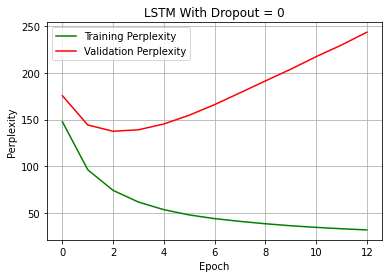

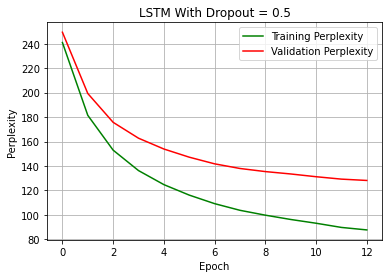

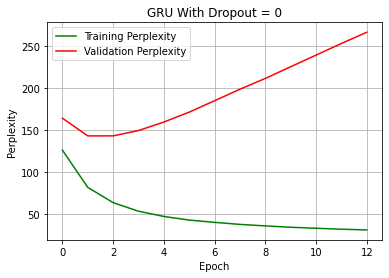

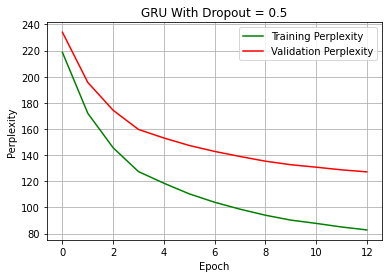

In [ ]:
for title in full_results_dict.keys():
  plot_prplx(full_results_dict[title][0],full_results_dict[title][1],title)

# Example of how to load a pre-trained model
*Decide which net type ('LSTM'/'GRU' with/without dropout), and link to the right path*

In [ ]:
model = modular_RNN_Model(vocab_size, embed_size, hidden_size, num_layers, 0, 'GRU')
model.load_state_dict(torch.load(f'{path}/Results/GRU With Dropout = 0_weights.pth'))
model.eval()

modular_RNN_Model(
  (embed): Embedding(10000, 128)
  (linear): Linear(in_features=200, out_features=10000, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (gru): GRU(128, 200, batch_first=True)
)